# Downscale & clip large raster data files
- useful if really they can't be downloaded programmatically for the AOI (area of interest)
- decreases storage and RAM req
- raster is often at very high spatial res (eg. 10s of meter for S2), which is not needed for PyPSA

In [2]:
# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
import os
working_directory = os.path.dirname(IPython.extract_module_locals()[1]['__vsc_ipynb_file__'])
os.chdir(os.path.join(os.path.dirname(working_directory), "scripts"))
os.getcwd()

'/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts'

In [3]:
import rioxarray, pandas as pd
import xarray as xr 
import geopandas as gpd

from constants import CRS

## functions

In [4]:

def xarr_to_gdf(
    xarr: xr.DataArray, var_name: str, x_var="x", y_var="y", crs=CRS
) -> gpd.GeoDataFrame:
    """convert an xarray to GDF

    Args:
        xarr (xr.DataArray): the input array
        var_name (str): the array variable to be converted.
        x_var (str, optional): the x dimension. Defaults to "x".
        y_var (str, optional): the y dimension. Defaults to "y".
        crs (_type_, optional): the crs. Defaults to CRS.

    Returns:
        gpd.GeoDataFrame: geodata frame in chosen CRS
    """
    df = xarr.to_dataframe()
    df.reset_index(inplace=True)
    return gpd.GeoDataFrame(
        df[var_name], geometry=gpd.points_from_xy(df[x_var], df[y_var]), crs=crs
    )

In [5]:
def coarsen_and_clip(paths:list[os.PathLike], region_gdf: gpd.GeoDataFrame, region_name:str, downscale = 10):
    """coarsen high res satellite data and clip to region of interest and Save new files

    Args:
        paths (list[os.PathLike]): the raster paths list
        region_gdf (gpd.GeoDataFrame): the shape file to clip to
        region_name (str): the name of the region (for file identification)
        downscale (int, optional): the factor to corasen by. Defaults to 10.
    """    
    for p in paths:
        ds = rioxarray.open_rasterio(p, chunks={'x': 1000, 'y': 1000})
        ds = ds.coarsen(x=downscale, y=downscale, boundary="pad").mean()
        ds = ds.rio.clip(region_gdf.geometry.values, region_gdf.crs)
        ds = ds.where(ds <= 100, other=100)
        ds.rio.to_raster(f"{os.path.splitext(p)[0]}_clipped_{region_name}.tif")



# get shape to which to clip

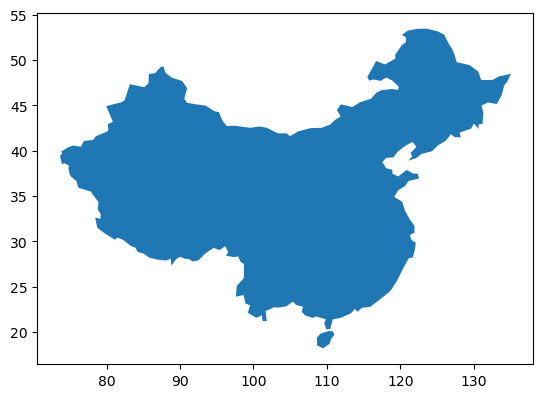

In [6]:
geo_path = os.path.realpath("../../resources/data/regions/regions_onshore.geojson")
region_shape = gpd.read_file(geo_path)
region_shape.plot()
shape_name = "china"

## downscale data
GLC sentinel analysis is at 100m, downscale to 1x1km2

In [28]:
paths = [os.path.join("/home/ivanra/documents/PyPSA-China-PIK/resources/data/landuse_availability/", raster) for raster in ["Bare.tif", "Build_up.tif","Grass.tif", "Shrubland.tif"]]
coarsen_and_clip(paths, region_shape, shape_name, downscale=10)

In [29]:
provs = gpd.read_file("../../resources/data/province_shapes/CHN_adm1.shp")

provs=provs[provs.province.isin(["Anhui", "Jiangsu", "Shanghai"])]
provs_ = gpd.GeoSeries(provs.union_all())

In [32]:
import shutil

paths_clipped = [os.path.join("/home/ivanra/documents/PyPSA-China-PIK/resources/data/landuse_availability/", raster) for raster in ["Bare_clipped_china.tif", "Build_up_clipped_china.tif","Grass_clipped_china.tif", "Shrubland_clipped_china.tif",]]
coarsen_and_clip(paths_clipped, provs_, "tests",5)
destination_folder = os.path.realpath("../../tests/testdata")
os.makedirs(destination_folder, exist_ok=True)

test_files= []
for p in paths_clipped:
    base_name = os.path.basename(p)
    new_name = os.path.basename(paths_clipped[0]).split("_clipped")[0]+".tif"
    shutil.move(f"{os.path.splitext(p)[0]}_clipped_tests.tif", os.path.join(destination_folder, new_name))
    test_files.append(os.path.join(destination_folder, new_name))

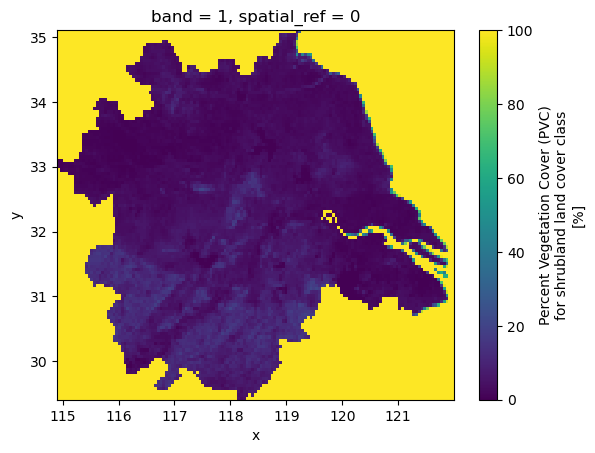

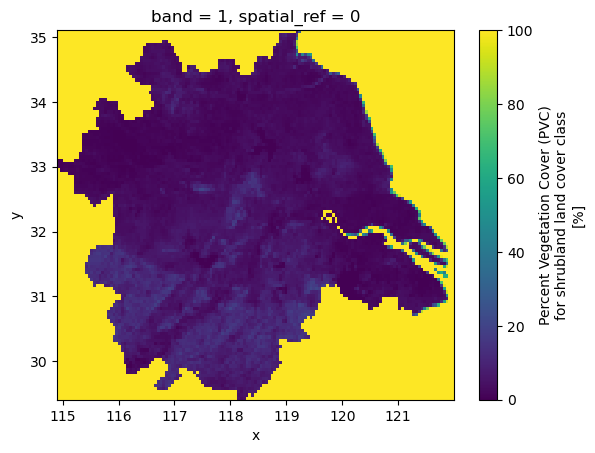

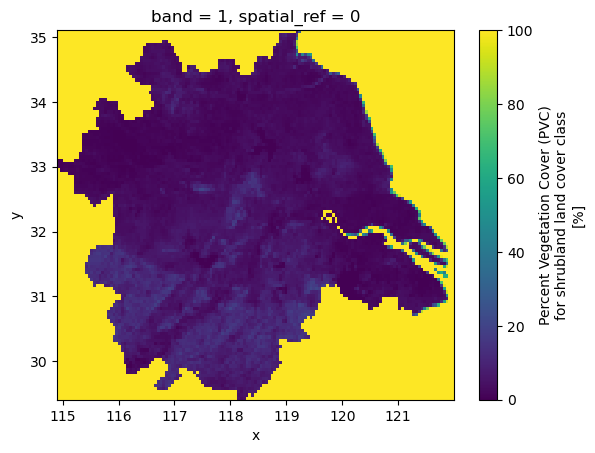

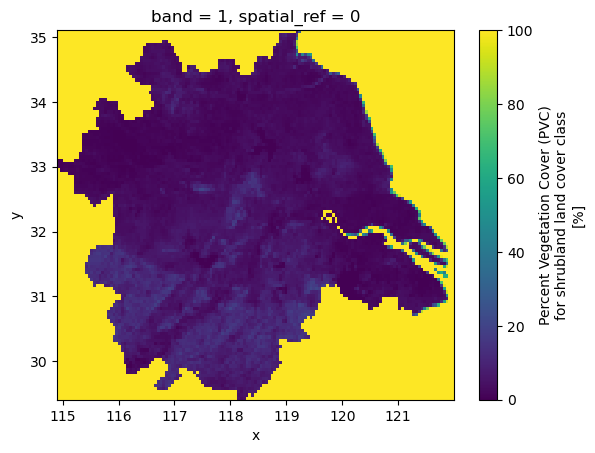

In [34]:
import matplotlib.pyplot as plt

for p in test_files:
    fig, ax = plt.subplots()
    ds = rioxarray.open_rasterio(p)
    ds.plot(ax=ax)


# gepbco bathimetry

In [8]:
ds = rioxarray.open_rasterio("/home/ivanra/documents/PyPSA-China-PIK/resources/data/landuse_availability/GEBCO_tiff/gebco_2024_CN.tif")
# its wg84
ds.rio.write_crs("epsg:4326", inplace=True)   
ds.coords["crs"] = 4326
ds

<xarray.DataArray 'elevation' (band: 1, y: 7721, x: 10061)> Size: 155MB
[77680981 values with dtype=int16]
Coordinates:
  * band     (band) int64 8B 1
  * x        (x) float64 80kB 91.96 91.96 91.97 91.97 ... 133.9 133.9 133.9
  * y        (y) float64 62kB 45.77 45.77 45.76 45.76 ... 13.61 13.61 13.61
    crs      int64 8B 4326
Attributes: (12/63)
    lat#axis:                        Y
    lat#long_name:                   latitude
    lat#sdn_parameter_name:          Latitude north
    lat#sdn_parameter_urn:           SDN:P01::ALATZZ01
    lat#sdn_uom_name:                Degrees north
    lat#sdn_uom_urn:                 SDN:P06::DEGN
    ...                              ...
    sdn_uom_urn:                     SDN:P06::ULAA
    standard_name:                   height_above_mean_sea_level
    units:                           m
    _FillValue:                      -32767
    scale_factor:                    1.0
    add_offset:                      0.0

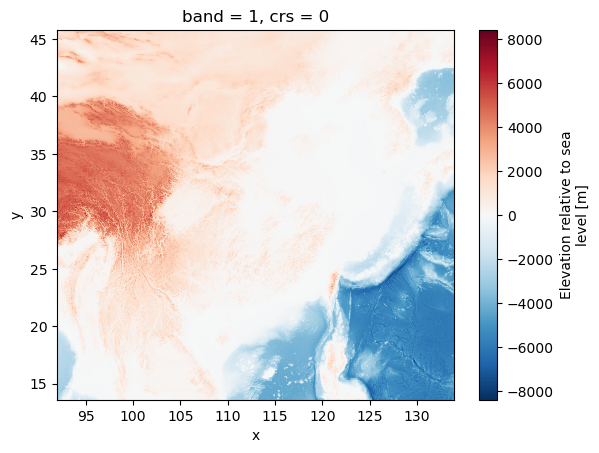

In [37]:
ds.plot()

In [25]:
downscale =24
ds_ = ds.coarsen(x=downscale, y=downscale, boundary="pad").mean()
ds_.rio.write_crs(4326, inplace=True)
# ds_ = ds_.rio.clip(region_shape.geometry.values, region_shape.crs)

<xarray.DataArray 'elevation' (band: 1, y: 322, x: 420)> Size: 541kB
array([[[ 1247.6597 ,  1239.1909 ,  1284.0503 , ...,   134.48611,
           153.21701,   178.375  ],
        [ 1156.2257 ,  1170.0486 ,  1166.1216 , ...,   136.94792,
           182.23958,   231.20833],
        [ 1125.6545 ,  1152.0469 ,  1147.9618 , ...,   121.71701,
           155.23264,   218.225  ],
        ...,
        [-3059.7344 , -2738.9932 , -2402.5903 , ..., -5259.271  ,
         -5188.7534 , -5082.092  ],
        [-2934.8801 , -2582.2395 , -2383.0486 , ..., -4893.0176 ,
         -5099.4707 , -5059.0083 ],
        [-2734.4558 , -2381.9167 , -1948.6863 , ..., -4824.8604 ,
         -4797.0537 , -4987.4473 ]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 92.01 92.11 92.21 92.31 ... 133.7 133.8 133.9
  * y            (y) float64 3kB 45.73 45.63 45.53 45.43 ... 13.83 13.73 13.64
    crs          int64 8B 4326
    spatial_ref  int64 8B 0
Attributes: (12/63)
    lat#axis:                        Y
    lat#long_name:                   latitude
    lat#sdn_parameter_name:          Latitude north
    lat#sdn_parameter_urn:           SDN:P01::ALATZZ01
    lat#sdn_uom_name:                Degrees north
    lat#sdn_uom_urn:                 SDN:P06::DEGN
    ...                              ...
    sdn_uom_urn:                     SDN:P06::ULAA
    standard_name:                   height_above_mean_sea_level
    units:                           m
    _FillValue:                      -32767
    scale_factor:                    1.0
    add_offset:                      0.0

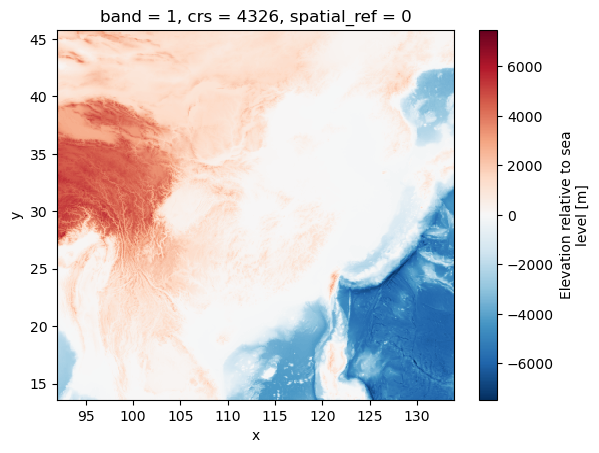

In [26]:
ds_.plot()
ds_.rio.to_raster("/home/ivanra/documents/PyPSA-China-PIK/resources/data/landuse_availability/GEBCO_tiff/gebco_2024_CN_tests.tif")